In [1]:
from striped.job import SinglePointStripedSession as Session, IPythonDisplay
from vega import VegaLite

import cloudpickle
import zlib

import uproot, uproot_methods
import awkward
import numpy as np

import fnal_column_analysis_tools
from fnal_column_analysis_tools.lookup_tools import extractor
from fnal_column_analysis_tools.lookup_tools import evaluator 
from fnal_column_analysis_tools.analysis_objects import JaggedCandidateArray

In [2]:
mc_f = open('mc_datasets.txt','r').readlines()
mc_datasets = [i.strip() for i in mc_f]

datasets = ["ZZTo2L2Nu_13TeV_powheg_pythia8"
            #"ST_s-channel_4f_InclusiveDecays_13TeV-amcatnlo-pythia8",    
           #"MET_NanoTuples-Data2017_Run2017B-31Mar2018-v1_2017",       
           #"WminusH_HToBB_WToLNu_M125_13TeV_powheg_pythia8",
           # "MET_NanoTuples-Data2017_Run2017C-31Mar2018-v1_2017",
        #"DYJetsToLL_M-50_HT-100to200_TuneCP5_13TeV-madgraph_2017MLM-pythia8_2017",
           ]

In [3]:
extractor = fnal_column_analysis_tools.lookup_tools.extractor()
extractor.add_weight_sets(['* * lookup_tables/eleTrig.root','* * lookup_tables/muon_trig_Run2016BtoF.root',
                           '* * lookup_tables/EIDISO_WH_out.json',
                           '* * lookup_tables/Tight27AfterIDISO_out.json',
                           '* * lookup_tables/failingVeto_out.json', 
                           '* * lookup_tables/ElectronID_SFs_WP90.root',
                           '* * lookup_tables/ScaleFactor_etracker_80x.json', 
                           '* * lookup_tables/kfactor_24bins.root'])
extractor.finalize()

evaluator = extractor.make_evaluator()

pickle_evaluator = zlib.compress(cloudpickle.dumps(evaluator))

In [4]:
#__worker_class__
import numpy as np
import zlib
import cloudpickle

import uproot, uproot_methods
import fnal_column_analysis_tools
from fnal_column_analysis_tools.lookup_tools import extractor
from fnal_column_analysis_tools.lookup_tools import evaluator 
from fnal_column_analysis_tools.analysis_objects import JaggedCandidateArray

from collections import OrderedDict

import awkward
#import numba
#from collections import OrderedDict
#import matplotlib.pyplot as plt
##%matplotlib inline
#from fnal_column_analysis_tools import hist

class Worker(object):
    
    Columns = ["Photon.pt","Photon.eta","Photon.phi","Photon.mass","Jet.pt","Jet.eta","Jet.phi","Jet.mass","Jet.jetId",
              "Electron.pt","Electron.eta","Electron.phi","Electron.mass","Electron.pfRelIso03_all","Electron.dxy",
               "Electron.dz","Electron.cutBased","Electron.charge","Electron.deltaEtaSC",
               "Electron.mvaSpring16GP_WP80","Electron.mvaSpring16GP_WP90","Muon.pt","Muon.eta","Muon.phi","Muon.mass",
               "Muon.pfRelIso04_all","Muon.dxy","Muon.dz","Muon.charge","Muon.tightId",
               "nElectron","nMuon","nJet","nPhoton","nGenPart","nTau","nAK15Puppi",
               "MET_pt","MET_phi",
               "GenPart.pt","GenPart.eta","GenPart.phi",
               "GenPart.mass","GenPart.pdgId","GenPart.status","GenPart.statusFlags","GenPart.genPartIdxMother",
               "Tau.pt","Tau.eta","Tau.phi","Tau.mass","Tau.idDecayMode","Tau.idMVAnew",
               "AK15Puppi.pt","AK15Puppi.eta","AK15Puppi.phi","AK15Puppi.mass","AK15Puppi.jetId"]
    
    
    def run(self, events, job, db):
        dtype = job["dtype"]
        hists = job["hists"]
        dataset = job["dataset"]
                
        photon_columns   = {'pt':events.Photon.pt,'eta':events.Photon.eta,'phi':events.Photon.phi,
                             'mass':events.Photon.mass}
        
        jet_columns      = {'pt':events.Jet.pt,'eta':events.Jet.eta,'phi':events.Jet.phi,
                            'mass':events.Jet.mass,'id':events.Jet.jetId}

        fat_jet_columns = {'pt':events.AK15Puppi.pt,'eta':events.AK15Puppi.eta,'phi':events.AK15Puppi.phi,
                           'mass':events.AK15Puppi.mass,'jetId':events.AK15Puppi.jetId}
        
        electron_columns = {'pt':events.Electron.pt,'eta':events.Electron.eta,'phi':events.Electron.phi,
                            'mass':events.Electron.mass,
                            'iso':events.Electron.pfRelIso03_all,'dxy':events.Electron.dxy,
                            'dz':events.Electron.dz, 'cid':events.Electron.cutBased,
                            'charge':events.Electron.charge,
                            'deltaEtaSC':events.Electron.deltaEtaSC, 
                            'mva_WP80':events.Electron.mvaSpring16GP_WP80,
                          #  'cutBased_HLTPreSel':events.Electron.cutBased_HLTPreSel,
                            'mva_WP90':events.Electron.mvaSpring16GP_WP90}
        
        muon_columns     = {'pt':events.Muon.pt,'eta':events.Muon.eta,'phi':events.Muon.phi,
                             'mass':events.Muon.mass,'iso':events.Muon.pfRelIso04_all,
                             'dxy':events.Muon.dxy,'dz':events.Muon.dz,'charge':events.Muon.charge,
                             'cid':events.Muon.tightId}
            
                                 
        tau_columns      = {'pt':events.Tau.pt,'eta':events.Tau.eta,'phi':events.Tau.phi,
                            'mass':events.Tau.mass, 'decayMode':events.Tau.idDecayMode, 
                            'id':events.Tau.idMVAnew}
        
  #     if 'mc' in dtype:
  #          electron_columns.update({'pdgId':events.Electron.pdgId}) 
            
  #          muon_columns.update({'pdgId':events.Muon.pdgId})
                         
        gen_columns      = {'pt':events.GenPart.pt,'eta':events.GenPart.eta,'phi':events.GenPart.phi,
                            'mass':events.GenPart.mass,
                            'id':events.GenPart.pdgId,'status':events.GenPart.status,
                            'statusFlags':events.GenPart.statusFlags,
                            'mIdx':events.GenPart.genPartIdxMother}
          
        eval_pickle = job["evaluator"]
        eval_pickle = zlib.decompress(eval_pickle)
        evaluator = cloudpickle.loads(eval_pickle)
       
       # triggers  = {'SingleEle':np.prod([arrays[val] for val in singleele_trigger_columns],axis=0)}
    
        electrons = JaggedCandidateArray.candidatesfromcounts(events.nElectron,
                **{key:val for key,val in electron_columns.items()})
        muons     = JaggedCandidateArray.candidatesfromcounts(events.nMuon, 
                **{key:val for key,val in muon_columns.items()})             
        photons   = JaggedCandidateArray.candidatesfromcounts(events.nPhoton, 
               **{key:val for key,val in photon_columns.items()})
        jets      = JaggedCandidateArray.candidatesfromcounts(events.nJet, 
               **{key:val for key,val in jet_columns.items()})
        fat_jets = JaggedCandidateArray.candidatesfromcounts(events.nAK15Puppi,
               **{key:val for key,val in fat_jet_columns.items()})
        genPart   = JaggedCandidateArray.candidatesfromcounts(events.nGenPart, 
               **{key:val for key,val in gen_columns.items()})
        taus      = JaggedCandidateArray.candidatesfromcounts(events.nTau, 
               **{key:val for key,val in tau_columns.items()})                                                         

        met_vec = uproot_methods.TLorentzVectorArray.from_ptetaphi(events.MET_pt,0,events.MET_phi,0)

        
        # end initialize
           
             # physical objects selection
        loose_electron_selection = (electrons.pt>7)&(abs(electrons.eta)<2.4)&((electrons.cid&2)!=0)&(electrons.mva_WP80)  
        #(electrons.cid&2)!=0 for loose selection 
        tight_electron_selection = (electrons.pt>40)&(abs(electrons.eta)<2.4)&((electrons.cid&4)!=0)&(electrons.mva_WP80) #(electrons.cid&4)!=0 for tight selection
        loose_muon_selection =  (muons.pt>5)&(abs(muons.eta)<2.4)   # "isLooseMuon" is already added in muon object
        tight_muon_selection =  (muons.pt>10)&(abs(muons.eta)<2.4)&(muons.cid)   # muons.cid for tight muon selection
        loose_photon_selection = (photons.pt>15)&(abs(photons.eta)<2.5)
        #&((photons.cid&1)!=0)  #(photons.cid&1)!=0 for loose selection 
        tight_photon_selection = (photons.pt>175)&(abs(photons.eta)<2.5)#&((photons.cid&3)!=0) #(photons.cid&3)!=0 for tight selection 
        tau_selection = (taus.pt>18)&(abs(taus.eta)<2.3)&(taus.decayMode)&((taus.id&2)!=0)
        fat_jet_selection = (fat_jets.pt > 200)&(abs(fat_jets.eta)<2.4)&(fat_jets.jetId > 0)
        jet_selection = (jets.pt>25)&(abs(jets.eta)<4.5)&((jets.id&2)!=0)

        loose_electrons = electrons[loose_electron_selection]
        tight_electrons = electrons[tight_electron_selection]
        loose_muons = muons[loose_muon_selection]
        tight_muons = muons[tight_muon_selection]
        loose_photons = photons[loose_photon_selection]
        tight_photons = photons[tight_photon_selection]
        selected_taus = taus[tau_selection]
        selected_fat_jets = fat_jets[fat_jet_selection]
        selected_jets = jets[jet_selection]
        jet_combinations = selected_jets.p4.cross(loose_electrons.p4, nested=True)
        mask = (jet_combinations.i0.delta_r(jet_combinations.i1) < 0.3 ).any()
        e_clean_jets = selected_jets[~mask]

        jet_combinations = e_clean_jets.p4.cross(loose_muons.p4, nested=True)
        mask = (jet_combinations.i0.delta_r(jet_combinations.i1) < 0.3).any()
        clean_jets = e_clean_jets[~mask]

        # once merge is done
        # mask = selected_jets.p4.match(clean_electrons.p4, 0.3)
        # clean_jets = selected_jets[~mask]
            # end cleaning

        tight_electron_selection = ((loose_electrons.pt > 30)&#(loose_electrons.id)&
                                  (loose_electrons.mva_WP80)&(loose_electrons.iso < 0.06))

        tight_electrons = loose_electrons[tight_electron_selection]
        tight_electrons_1L =tight_electrons
        
        clean_electrons = loose_electrons
        clean_muons = loose_muons
        clean_fat_jets = selected_fat_jets
        
                #Get recoils
            #ARH - this could be improved by defining a single recoil object regardless of region. 
        pfUA = self.get_recoil(met_vec,loose_photons)
        pfUWe = self.get_recoil(met_vec,clean_electrons)
        pfUWm = self.get_recoil(met_vec,clean_muons)
        
            #End of recoils
            
            #TODO Get dPhi
            

            #signal and control region selections
        preselection = (selected_taus.counts==0)&(clean_fat_jets.counts>0)
        
        
                #No triggers are applied yet!
        
        selections = OrderedDict()
        #Still need to add the dphimet cut
        selections['signal'] = preselection&(clean_muons.counts==0)&(clean_electrons.counts==0)&(loose_photons.counts==0)&(met_vec.pt>200)
        #Need to calculate and dphipfUW and mt and apply cuts of dphipfUW>0.8 && mT<160'. Need one tight muon.
        selections['mn'] = preselection&(clean_muons.counts==1)&(clean_electrons.counts==0)&(loose_photons.counts==0)&(pfUWm.pt>200)
         #Need to calculate pfUWmag and dphipfUW and mt and apply cuts pfUWmag>200 && dphipfUW>0.4 && mT<160'. Need one tight electron
        selections['en'] = preselection&(clean_muons.counts==0)&(clean_electrons.counts==1)&(loose_photons.counts==0)&(pfUWe.pt>50)
        #Need at least one tight muon, 60<diLepMass && diLepMass<120, pfUZmag>200 && dphipfUZ>0.8
        selections['zmm'] = preselection&(clean_muons.counts==2)&(clean_electrons.counts==0)&(loose_photons.counts==0)
        #Need at least one tight electron, 60<diLepMass && diLepMass<120, pfUZmag>200 && dphipfUZ>0.8 
        selections['zee'] = preselection&(clean_muons.counts==0)&(clean_electrons.counts==2)&(loose_photons.counts==0)
        #Need loosePho1IsTight, pfUAmag>200 && dphipfUA>0.8
        selections['pho'] = preselection&(clean_muons.counts==0)&(clean_electrons.counts==0)&(loose_photons.counts==1) 
        
        genPart_1LSfe_selection = (abs(genPart.id==11))&(genPart.statusFlags&1 !=0)&(genPart.statusFlags&8192 != 0)

        gen_prompt_electrons = genPart[genPart_1LSfe_selection]
        gen_electrons_combinations = tight_electrons.p4.cross(gen_prompt_electrons.p4,nested=True)
        gen_electrons_mask = (gen_electrons_combinations.i0.delta_r(gen_electrons_combinations.i1)<0.4).any()

        _1L_electrons = tight_electrons[gen_electrons_mask]
        weight, weight_up, weight_down = self.calculateEleWeights(evaluator, _1L_electrons)
        
        weight = weight*job['xsec_weight']
        weight_up = weight_up*job['xsec_weight']
        weight_down = weight_down*job['xsec_weight']
        
        dielectron_selection = (tight_electrons.counts>0)&(clean_jets.counts==0)#&(triggers["SingleEle"]==1)#&(loose_photons.counts==0)

        dielectrons = loose_electrons[dielectron_selection].distincts()
        dielectron_mass = dielectrons.mass
        e_weight = weight[dielectron_selection][dielectrons.counts>0]
        dielectron_mass = dielectron_mass[dielectron_mass.counts>0][:,0]
        
        for region in selections:
            hists['recoil'].fill(dataset=dataset,region=region,recoil=met_vec[selections[region]].pt.flatten()) 
   #        hists['dPhi']
            hists['fjPt'].fill(dataset=dataset,   region=region, fjPt=clean_fat_jets[selections[region]].pt.flatten())
            hists['fjEta'].fill(dataset=dataset,  region=region, fjEta=clean_fat_jets[selections[region]].eta.flatten())
            hists['phoPt'].fill(dataset=dataset,  region=region, phoPt=loose_photons[selections[region]].pt.flatten())
            hists['phoEta'].fill(dataset=dataset, region=region, phoEta=loose_photons[selections[region]].eta.flatten())
            hists['elePt'].fill(dataset=dataset,  region=region, elePt=clean_electrons[selections[region]].pt.flatten())
            hists['eleEta'].fill(dataset=dataset, region=region, eleEta=clean_electrons[selections[region]].eta.flatten())
            hists['muPt'].fill(dataset=dataset,   region=region, muPt=clean_muons[selections[region]].pt.flatten())
            hists['muEta'].fill(dataset=dataset,  region=region, muEta=clean_muons[selections[region]].eta.flatten())
            #hists[''].fill(dataset=dataset,region=region,=.flatten())

        job.send(hists=hists)

        
    def calculateEleWeights(self, evaluator, electrons):
        sfReco = np.ones(electrons.size)
        sfReco_up = np.ones(electrons.size)
        sfReco_down = np.ones(electrons.size)
        sfTrig = np.ones(electrons.size)
        sfTrig_up = np.ones(electrons.size)
        sfTrig_down = np.ones(electrons.size)
        sfIdIso = np.ones(electrons.size)
        sfIdIso_up = np.ones(electrons.size)
        sfIdIso_down = np.ones(electrons.size)
        sfId = np.ones(electrons.size)
        sfId_up = np.ones(electrons.size)
        sfId_down = np.ones(electrons.size)

        sfReco_value  = 'ScaleFactor_tracker_80x/eta_pt_ratio_value'
        sfReco_error  = 'ScaleFactor_tracker_80x/eta_pt_ratio_error'
        sfIdIso_value = 'EIDISO_WH/eta_pt_ratio_value'
        sfIdIso_error = 'EIDISO_WH/eta_pt_ratio_error'
        sfTrig_value  = 'Tight27AfterIDISO/eta_pt_ratio_value'
        sfTrig_error  = 'Tight27AfterIDISO/eta_pt_ratio_error'

        c =electrons.counts
        etaSC = electrons.eta+electrons.deltaEtaSC
        pt = electrons.pt
        sfReco[c>0] = evaluator[sfReco_value](etaSC,pt)[c>0][:,0]
        sfReco_up[c>0] = sfReco[c>0] + evaluator[sfReco_error](etaSC,pt)[c>0][:,0]
        sfReco_down[c>0] = sfReco[c>0] - evaluator[sfReco_error](etaSC,pt)[c>0][:,0]
        sfReco_up[c>0][electrons[c>0].pt[:,0] >80] = sfReco_up[c>0][electrons[c>0].pt[:,0] >80] + 0.01
        sfReco_down[c>0][electrons[c>0].pt[:,0] >80] = sfReco_down[c>0][electrons[c>0].pt[:,0] >80] - 0.01

        sfIdIso[c >0] = evaluator[sfIdIso_value](etaSC,pt)[c>0][:,0]
        sfIdIso_up[c>0] = sfIdIso[c > 0] + evaluator[sfIdIso_error](etaSC,pt)[c>0][:,0]
        sfIdIso_down[c>0] =sfIdIso[c > 0] - evaluator[sfIdIso_error](etaSC,pt)[c>0][:,0]

        sfTrig[c>0] = evaluator[sfTrig_value](etaSC,pt)[c>0][:,0]
        sfTrig_up[c>0] = sfTrig[c>0] + evaluator[sfTrig_error](etaSC, pt)[c>0][:,0]
        sfTrig_down[c>0] =sfTrig[c>0] - evaluator[sfTrig_error](etaSC,pt)[c>0][:,0]

        weight = sfTrig*sfIdIso*sfId*sfReco
        weight_up = sfTrig_up*sfIdIso_up*sfId*sfReco_up
        weight_down = sfTrig_down*sfIdIso_down*sfId*sfReco_down

        return weight, weight_up, weight_down
    
    def get_recoil(self,met,add_objects):
        #ARH: This worked until an update in awkward. Have to wait for a new release then it should work again
        #highest_pt = add_objects.p4[add_objects.pt.argmax()]
        
        #recoil = met.zeros_like()
        #recoil = recoil.cross(highest_pt)
        #recoil = (recoil.i0+recoil.i1+met).p4
        
        recoil = met
        return recoil
        

In [5]:
import fnal_column_analysis_tools.hist as hist

dataset = hist.Cat("dataset", "DAS name")
region =  hist.Cat("region", "Control or Signal region")

hists = OrderedDict()
hists['recoil'] = hist.Hist("Events", dataset, region, hist.Bin("recoil", "Recoil (GeV)", [0.,100,200,300,400,600,1000,2000]))
hists['dPhi']   = hist.Hist("Events", dataset, region, hist.Bin("dPhi","Min dPhi(recoil,jets)",16,0,3.2))
hists['fjEta']  = hist.Hist("Events", dataset, region, hist.Bin("fjEta","Fat Jet Eta",50,-2.5,2.5))
hists['fjPt']   = hist.Hist("Events", dataset, region, hist.Bin("fjPt","Fat Jet Pt (GeV)",20,200,800))
hists['phoPt']  = hist.Hist("Events", dataset, region, hist.Bin("phoPt","Photon Pt (GeV)",20,200,800))
hists['phoEta'] = hist.Hist("Events", dataset, region, hist.Bin("phoEta","Photon Eta",50,-2.5,2.5))
hists['elePt']  = hist.Hist("Events", dataset, region, hist.Bin("elePt","Electron Pt (GeV)",20,200,800))
hists['eleEta'] = hist.Hist("Events", dataset, region, hist.Bin("eleEta","Electron Eta",50,-2.5,2.5))
hists['muPt']   = hist.Hist("Events", dataset, region, hist.Bin("muPt","Muon Pt (GeV)",20,200,800))
hists['muEta']  = hist.Hist("Events", dataset, region, hist.Bin("muEta","Muon Eta",50,-2.5,2.5))
#hists['']= hist.Hist("Events", dataset, region, hist.Bin())



In [6]:
from __future__ import print_function
import threading

class MyHistCollectorCallback(object):
    def __init__(self, hists, redraw_fcn, update=2e5):
        """
            hists: a dictionary of histograms that will be kept by reference and updated
                        with the partial results of the striped session
            redraw_fcn: a callable method that will redraw whatever histograms you want
                        to display in real time as the histograms are updated.  It must
                        return a list of figures
            update: the redraw function will only be called after this many events have
                        been collected from the striped workers
        """
        self._hists = hists
        self._redraw = redraw_fcn
        self._update = update
        self._seen = 0
        self._lock = threading.Lock()

    @property
    def lock(self):
        return self._lock

    def on_streams_update(self, nevents, data):
        """
            This method is called by striped
        """
        if "hists" in data:
            for key in data["hists"]:
                for key2 in key:
                    self._hists[key2] += key[key2]
        self._seen += nevents
        if self._seen > self._update:
            self._seen = 0
            self.update_histograms()
    
    def update_histograms(self):
        figs = self._redraw()
        for fig in figs:
            fig.canvas.draw()
    
    def on_exception(self, wid, info):
        print("Worker exception:")
        print(info)

In [7]:
session = Session("/Users/ahall/striped.yaml")


from fnal_column_analysis_tools.hist import plot

class PlotDrawer(object):    
    def __call__(self):
        figs = []
        return figs
class PlotDrawer(object):    
    def __call__(self):
        figs = []
        figs.append(self.draw_recoil())
        return figs
    
    def draw_recoil(self):
        figin = getattr(self, 'massfig', None)
        hist2d = hists['recoil'].project('dataset')
        fig, ax, temp= plot.plot1d(hist2d,overlay='region',ax=figin,fill_opts={})
        #fig, ax, temp= plot.plot1d(hist2d,ax=figin,fill_opts={})
        self.massfig = ax
        return fig
        
draw = PlotDrawer()
callback = MyHistCollectorCallback(hists, draw, update=1e6)
# This cell must stay separated from the update loop
# https://github.com/matplotlib/jupyter-matplotlib/issues/17
#figs = draw()

('ifdb02.fnal.gov', 8766)
(u'131.225.193.17', 8776)


ZZTo2L2Nu_13TeV_powheg_pythia8                                           8.842 M events,   0.171 M events/sec


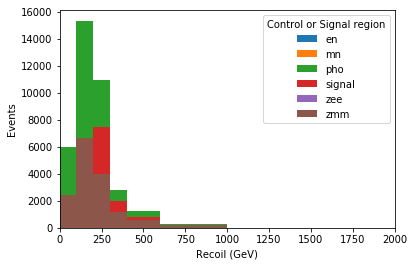

In [8]:
from xsec import xsecEval
for dataset_name in datasets:
    xsec_weight = xsecEval(dataset_name)
    
    if ("madgraph"in dataset_name) or ("pythia") in dataset_name:
        dtype = 'mc'
    else:
        dtype = 'data'
    job = session.createJob(dataset_name, 
        user_callback=callback,
        user_params = {"dataset":dataset_name,"dtype":dtype, "evaluator":pickle_evaluator, "hists":hists,
                       "xsec_weight":xsec_weight}
    )
    job.run()
    runtime = job.TFinish - job.TStart
    nevents = job.EventsProcessed
    print ("%-70s %7.3f M events, %7.3f M events/sec" % (dataset_name, float(nevents)/1000000, nevents/runtime/1000000))
figs = draw()

(1, 35309.63218478551)

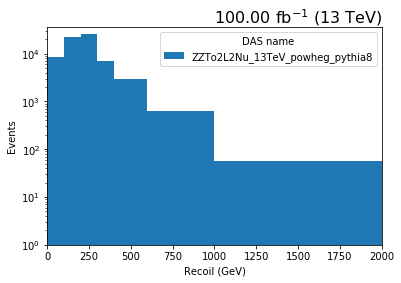

In [9]:
hist2d = hists['recoil'].project('region')

fig, ax, _ = plot.plot1d(hist2d,overlay='dataset',fill_opts={})  
lumi = 100
ax.text(1., 1., r"%.2f fb$^{-1}$ (13 TeV)" % (lumi), fontsize=16, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)
ax.set_yscale('log')
ax.autoscale(axis='y', tight=False)
ax.set_ylim(1, None)

(1, 3322.0803660381707)

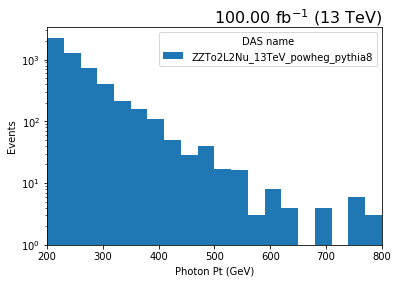

In [10]:
hist2d = hists['phoPt'].project('region','pho')

fig, ax, _ = plot.plot1d(hist2d,overlay='dataset',fill_opts={})  
lumi = 100
ax.text(1., 1., r"%.2f fb$^{-1}$ (13 TeV)" % (lumi), fontsize=16, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)
ax.set_yscale('log')
ax.autoscale(axis='y', tight=False)
ax.set_ylim(1, None)